In [117]:
import os
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, RobustScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.utils import to_categorical

# set path
train_feature_dir = '../2025_A2/train/Features'
train_metadata_path = '../2025_A2/train/train_metadata.csv'

In [118]:

# prepare features
color_df = pd.read_csv(os.path.join(train_feature_dir, 'color_histogram.csv'))
hog_df = pd.read_csv(os.path.join(train_feature_dir, 'hog_pca.csv'))
additional_df = pd.read_csv(os.path.join(train_feature_dir, 'additional_features.csv'))

def merge(meta):
    return (meta
            .merge(additional_df,  on="image_path")
            .merge(color_df, on="image_path")
            .merge(hog_df,    on="image_path"))

metadata_df = pd.read_csv(train_metadata_path)

X = merge(metadata_df).drop(columns=["ClassId", "image_path"])

In [119]:
# get train and validation sets
metadata_df = pd.read_csv(train_metadata_path)
y = metadata_df['ClassId']
y_encoded = to_categorical(y, num_classes=43)

scaler = StandardScaler()

X_train, X_val, y_train, y_val = train_test_split(X, y_encoded, test_size=0.1, random_state=42)

In [120]:
# establish model
model = Sequential([
    Dense(512, activation='relu', input_shape=(X_train.shape[1],)),
    Dropout(0.4),
    Dense(256, activation='relu'),
    Dropout(0.3),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(43, activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

X_train_scaled = scaler.fit_transform(X_train)
model.fit(X_train_scaled, y_train, epochs=10, batch_size=64)

Epoch 1/10
78/78 [==============================] - 1s 3ms/step - loss: 3.2073 - accuracy: 0.1766
Epoch 2/10
78/78 [==============================] - 0s 3ms/step - loss: 2.1094 - accuracy: 0.4159
Epoch 3/10
78/78 [==============================] - 0s 3ms/step - loss: 1.4990 - accuracy: 0.5420
Epoch 4/10
78/78 [==============================] - 0s 3ms/step - loss: 1.2181 - accuracy: 0.6119
Epoch 5/10
78/78 [==============================] - 0s 3ms/step - loss: 1.0384 - accuracy: 0.6669
Epoch 6/10
78/78 [==============================] - 0s 3ms/step - loss: 0.9107 - accuracy: 0.7060
Epoch 7/10
78/78 [==============================] - 0s 3ms/step - loss: 0.8446 - accuracy: 0.7151
Epoch 8/10
78/78 [==============================] - 0s 3ms/step - loss: 0.7748 - accuracy: 0.7396
Epoch 9/10
78/78 [==============================] - 0s 3ms/step - loss: 0.7231 - accuracy: 0.7574
Epoch 10/10
78/78 [==============================] - 0s 3ms/step - loss: 0.6644 - accuracy: 0.7783


18/18 [==============================] - 0s 835us/step
Hold-out accuracy : 0.7905282331511839
Balanced accuracy: 0.7615994937684599

Classification Report:
               precision    recall  f1-score   support

           0      1.000     0.333     0.500         3
           1      0.933     0.583     0.718        24
           2      0.733     0.647     0.688        34
           3      0.611     0.688     0.647        16
           4      0.694     0.862     0.769        29
           5      0.613     0.633     0.623        30
           6      1.000     1.000     1.000         3
           7      0.704     0.731     0.717        26
           8      0.545     0.429     0.480        14
           9      0.812     1.000     0.897        13
          10      0.795     0.886     0.838        35
          11      0.375     0.900     0.529        10
          12      1.000     1.000     1.000        29
          13      1.000     1.000     1.000        26
          14      0.933     1.00

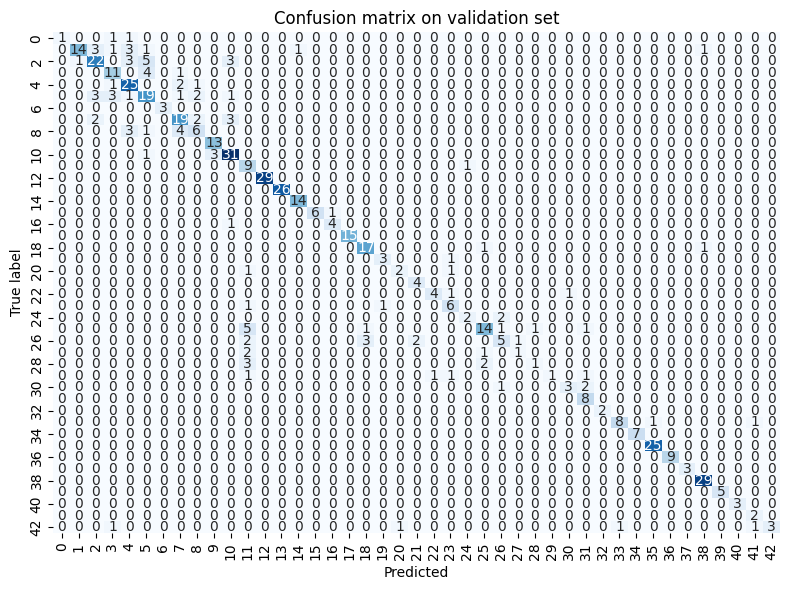

Macro-average ROC-AUC: 0.9927992151324417


C:\Users\Administrator\AppData\Local\Temp\ipykernel_17456\352706539.py:57: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  clf = KerasClassifier(build_fn=build_model, epochs=10, batch_size=64, verbose=0)



5-fold CV accuracy: 0.799 ± 0.016
5-fold CV F1-macro : 0.773 ± 0.011


In [121]:
# evaluation

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    accuracy_score, balanced_accuracy_score,
    classification_report, confusion_matrix, roc_auc_score
)
from sklearn.model_selection import StratifiedKFold, cross_val_score
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier

# Accuracy metrics
X_val_scaled = scaler.transform(X_val)
y_prob = model.predict(X_val_scaled)
y_pred = np.argmax(y_prob, axis=1)
y_val_int = np.argmax(y_val, axis=1)

print("Hold-out accuracy :", accuracy_score(y_val_int, y_pred))
print("Balanced accuracy:", balanced_accuracy_score(y_val_int, y_pred))
print("\nClassification Report:\n", classification_report(y_val_int, y_pred, digits=3))

# Confusion Matrix
cm = confusion_matrix(y_val_int, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel("Predicted")
plt.ylabel("True label")
plt.title("Confusion matrix on validation set")
plt.tight_layout()
plt.show()

# ROC-AUC
try:
    roc_auc = roc_auc_score(to_categorical(y_val_int, num_classes=43), y_prob, multi_class="ovr", average="macro")
    print("Macro-average ROC-AUC:", roc_auc)
except Exception as e:
    print("ROC-AUC skipped:", e)

# 5-fold
def build_model():
    from tensorflow.keras.models import Sequential
    from tensorflow.keras.layers import Dense, Dropout
    model = Sequential([
        Dense(512, activation='relu', input_shape=(X.shape[1],)),
        Dropout(0.4),
        Dense(256, activation='relu'),
        Dropout(0.3),
        Dense(128, activation='relu'),
        Dropout(0.3),
        Dense(43, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

clf = KerasClassifier(build_fn=build_model, epochs=10, batch_size=64, verbose=0)

y_int = np.argmax(y_encoded, axis=1)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

acc_scores = cross_val_score(clf, scaler.transform(X), y_int, cv=cv, scoring="accuracy", n_jobs=-1)
f1_scores = cross_val_score(clf, scaler.transform(X), y_int, cv=cv, scoring="f1_macro", n_jobs=-1)

print("\n5-fold CV accuracy: %.3f ± %.3f" % (acc_scores.mean(), acc_scores.std()))
print("5-fold CV F1-macro : %.3f ± %.3f" % (f1_scores.mean(), f1_scores.std()))


In [122]:
# 保存模型（可选）
model.save('../models/neural_model.h5')

In [123]:
feature_dir_test = '../2025_A2/test/Features'
meta_path_test = '../2025_A2/test/test_metadata.csv'

color_df_test = pd.read_csv(f"{feature_dir_test}/color_histogram.csv")
hog_df_test = pd.read_csv(f"{feature_dir_test}/hog_pca.csv")
additional_df_test = pd.read_csv(f"{feature_dir_test}/additional_features.csv")
def merge_test(meta):
    return (meta
            .merge(additional_df_test,  on="image_path")
            .merge(color_df_test, on="image_path")
            .merge(hog_df_test,    on="image_path"))

metadata_df_test = pd.read_csv(meta_path_test)

X_test = merge_test(metadata_df_test).drop(columns=["ClassId", "image_path"])

X_test_scaled = scaler.fit_transform(X_test)

proba_nn_test = model.predict(X_test_scaled)
y_pred_test = np.argmax(proba_nn_test, axis=1)
test_ids = pd.read_csv(meta_path_test)['id']
submission = pd.DataFrame({
    'id': test_ids,
    'ClassId': y_pred_test
})
submission.to_csv('../nn.csv', index=False)

74/74 [==============================] - 0s 781us/step
